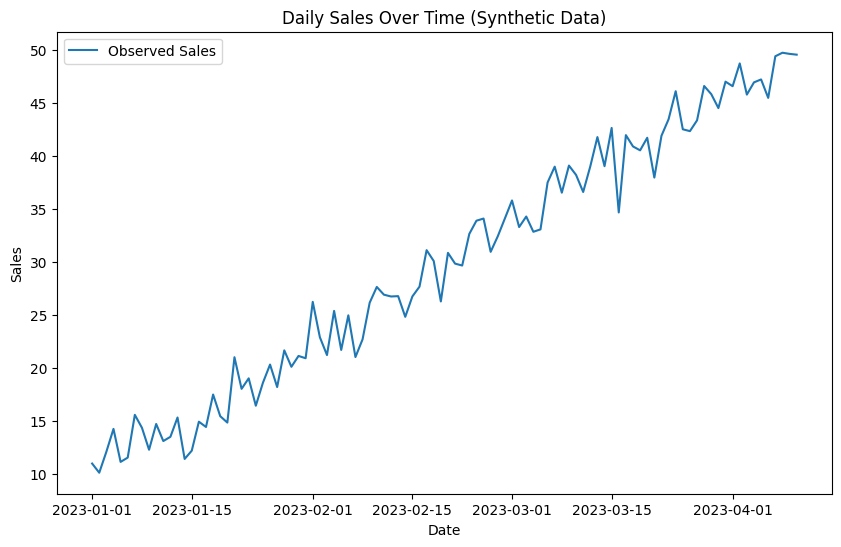

ADF Statistic: 0.09876067397506966
p-value: 0.9659763776183391


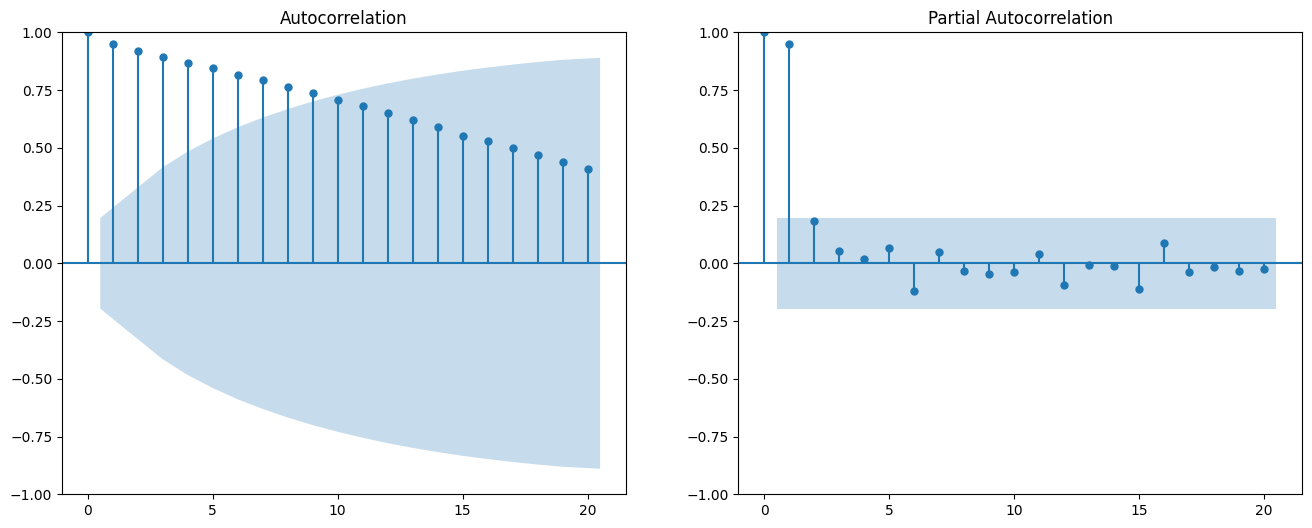

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -178.052
Date:                Mon, 26 Jan 2026   AIC                            362.104
Time:                        10:52:44   BIC                            369.212
Sample:                    01-01-2023   HQIC                           364.952
                         - 03-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1660      0.214     -0.774      0.439      -0.586       0.254
ma.L1         -0.4669      0.206     -2.269      0.023      -0.870      -0.064
sigma2         5.2825      0.875      6.036      0.0

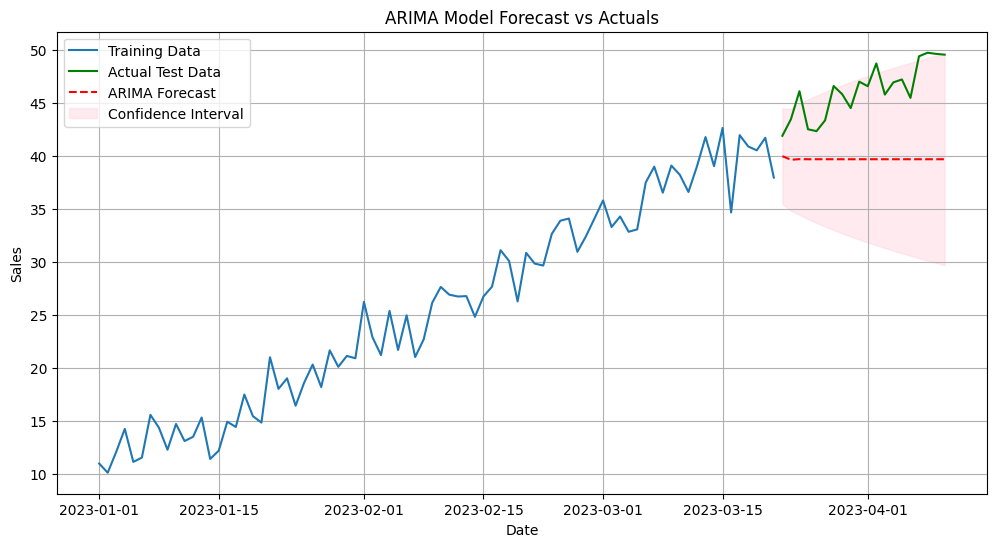

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# 1. Data Generation
# I am generating a synthetic dataset to simulate sales data with a trend and noise.
np.random.seed(123)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
values = np.linspace(10, 50, 100) + np.random.normal(0, 2, 100)  # Linear trend + noise
data = pd.DataFrame({'Date': dates, 'Sales': values})
data.set_index('Date', inplace=True)

# 2. Visualization of Raw Data
# Before modeling, I want to visually inspect the time series to identify trends.
plt.figure(figsize=(10, 6))
plt.plot(data['Sales'], label='Observed Sales')
plt.title('Daily Sales Over Time (Synthetic Data)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# 3. Stationarity Check (ADF Test)
# ARIMA requires data to be stationary. I'm using the Augmented Dickey-Fuller test.
result = adfuller(data['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, the data is non-stationary, and I need to rely on the 'd' parameter
# in ARIMA to handle differencing.

# 4. Autocorrelation Analysis
# I am plotting ACF and PACF to determine the potential 'p' and 'q' parameters.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data['Sales'], ax=ax1)
plot_pacf(data['Sales'], ax=ax2)
plt.show()

# 5. Train/Test Split
# I'm splitting the data to test the model's performance on unseen future points.
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

# 6. Building the ARIMA Model
# I chose order=(1, 1, 1) as a starting point:
# p=1 (AR term), d=1 (Differencing to remove trend), q=1 (MA term).
model = ARIMA(train['Sales'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# 7. Forecasting
# I am predicting the values for the test set range.
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 8. Visualization of Results
# Finally, I'm plotting the Training data, Actual Test data, and my Forecast.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Training Data')
plt.plot(test.index, test['Sales'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast_mean, label='ARIMA Forecast', color='red', linestyle='--')

# Adding confidence intervals (shading the uncertainty area)
plt.fill_between(test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('ARIMA Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Optimizing ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=408.742, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=392.570, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=366.798, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=407.960, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=368.782, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=368.772, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=383.056, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.739 seconds

Best Model Parameters found: (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -180.399
Date:                Mon, 26 Jan 2026   AIC             

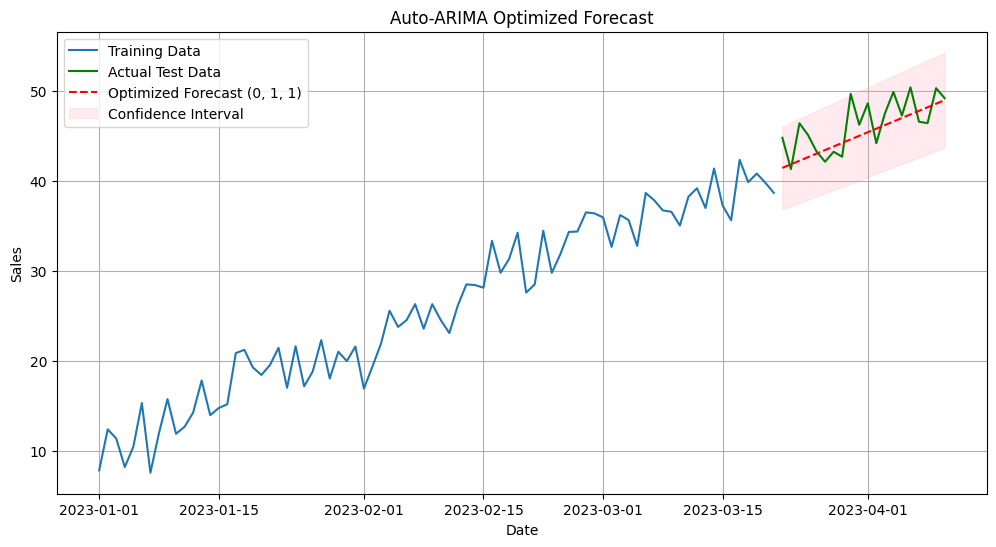

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Data Generation (Same as before)
# I'm simulating sales data with a trend and noise.
np.random.seed(123)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
values = np.linspace(10, 50, 100) + np.random.normal(0, 2, 100)
data = pd.DataFrame({'Date': dates, 'Sales': values})
data.set_index('Date', inplace=True)

# 2. Train/Test Split
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

# 3. Auto-ARIMA (The Optimization Step)
# Instead of guessing (1,1,1), I am using auto_arima to find the optimal hyperparameters.
# stepwise=True ensures it searches efficiently rather than checking every single combination.
print("Optimizing ARIMA parameters...")
auto_model = pm.auto_arima(train['Sales'],
                           start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           m=1,              # Frequency (1 for non-seasonal)
                           d=None,           # Let the model figure out differencing
                           seasonal=False,   # No seasonality in this specific dummy data
                           trace=True,       # Print the search progress
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(f"\nBest Model Parameters found: {auto_model.order}")
print(auto_model.summary())

# 4. Forecasting with the Best Model
# I'm predicting the test set using the optimized parameters.
forecast, conf_int = auto_model.predict(n_periods=len(test), return_conf_int=True)

# Make it a pandas series for easier plotting
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf_int[:, 0], index=test.index)
upper_series = pd.Series(conf_int[:, 1], index=test.index)

# 5. Evaluation Metrics
# I want to quantify "how well" it fits using RMSE and MAE.
mse = mean_squared_error(test['Sales'], forecast_series)
mae = mean_absolute_error(test['Sales'], forecast_series)
rmse = np.sqrt(mse)

print(f"\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 6. Visualization
# Plotting the optimized fit against the actual data.
plt.figure(figsize=(12, 6))
plt.plot(train['Sales'], label='Training Data')
plt.plot(test['Sales'], label='Actual Test Data', color='green')
plt.plot(forecast_series, label=f'Optimized Forecast {auto_model.order}', color='red', linestyle='--')
plt.fill_between(lower_series.index, lower_series, upper_series, color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Auto-ARIMA Optimized Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()